In [2]:
import torch
import cv2
import numpy as np
from PIL import Image

from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, LCMScheduler
from diffusers.utils import load_image, make_image_grid

controlnet = ControlNetModel.from_pretrained("diffusers/controlnet-canny-sdxl-1.0-small", torch_dtype=torch.float16, variant="fp16")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    variant="fp16"
).to("cuda")

# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")
pipe.fuse_lora()




Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


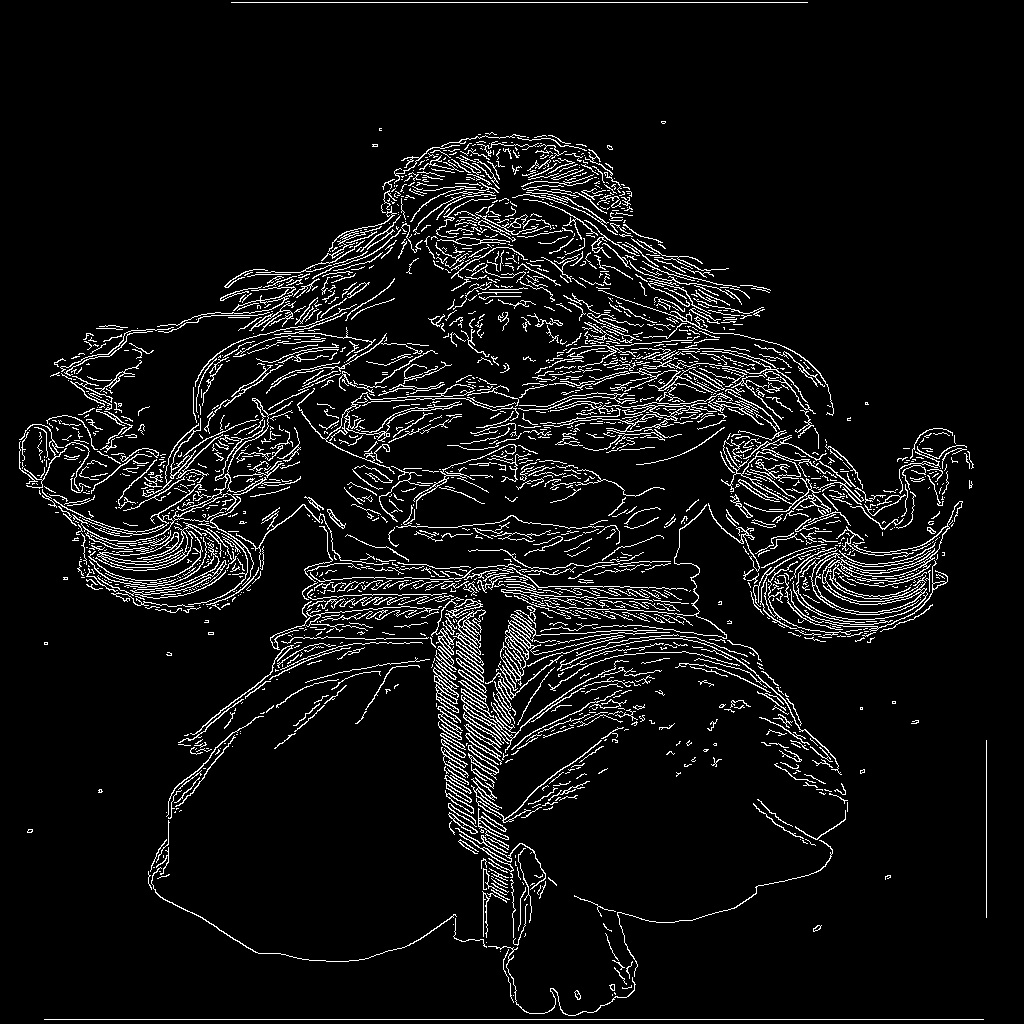

In [30]:
init_image = load_image(
    "./image/personagme.png"
).resize((1024, 1024))

image = np.array(init_image)

low_threshold = 50
high_threshold = 100

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_image

  0%|          | 0/5 [00:00<?, ?it/s]

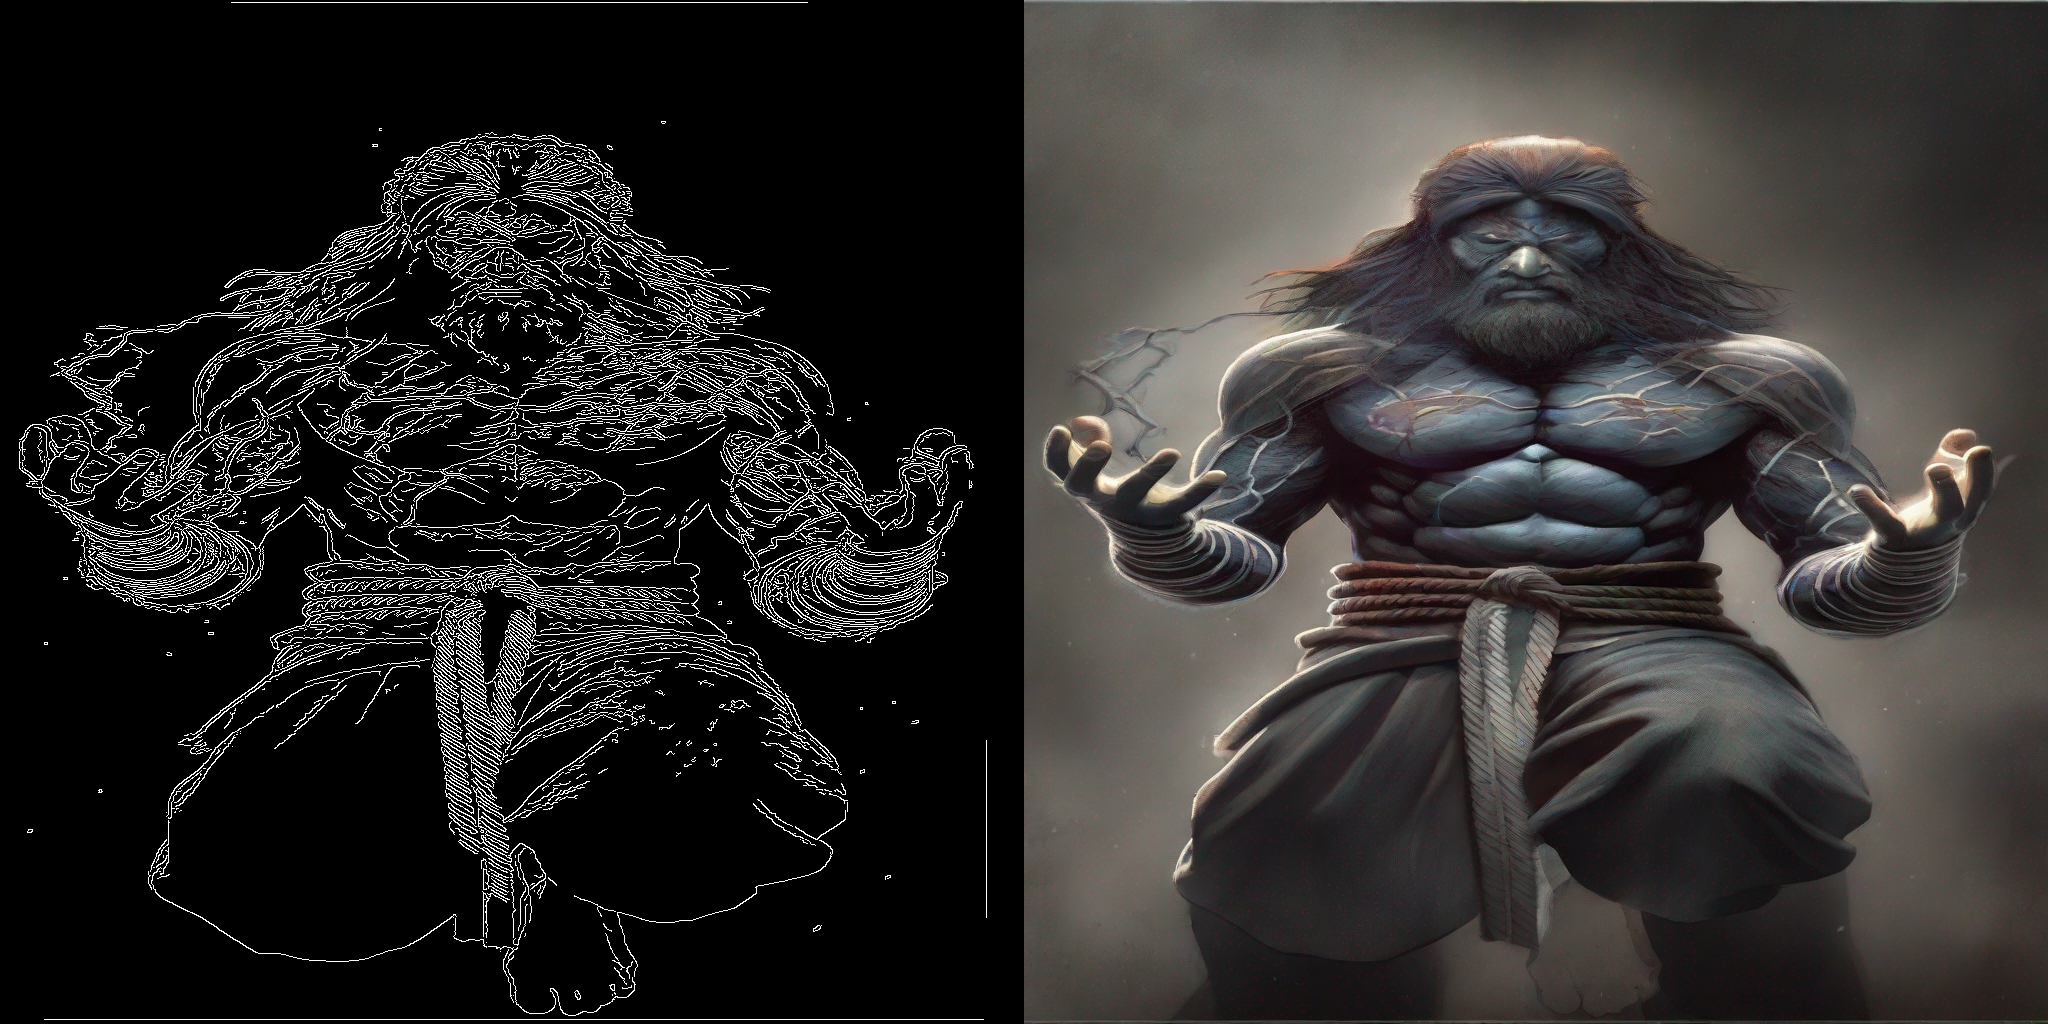

In [31]:
generator = torch.manual_seed(0)
image = pipe(
    "Templar, dark place background",
    negative_prompt="metal skin, helmet",
    image=canny_image,
    num_inference_steps=5,
    guidance_scale=0,
    controlnet_conditioning_scale=0.5,
    cross_attention_kwargs={"scale": 1},
    # generator=generator,
).images[0]
make_image_grid([canny_image, image], rows=1, cols=2)

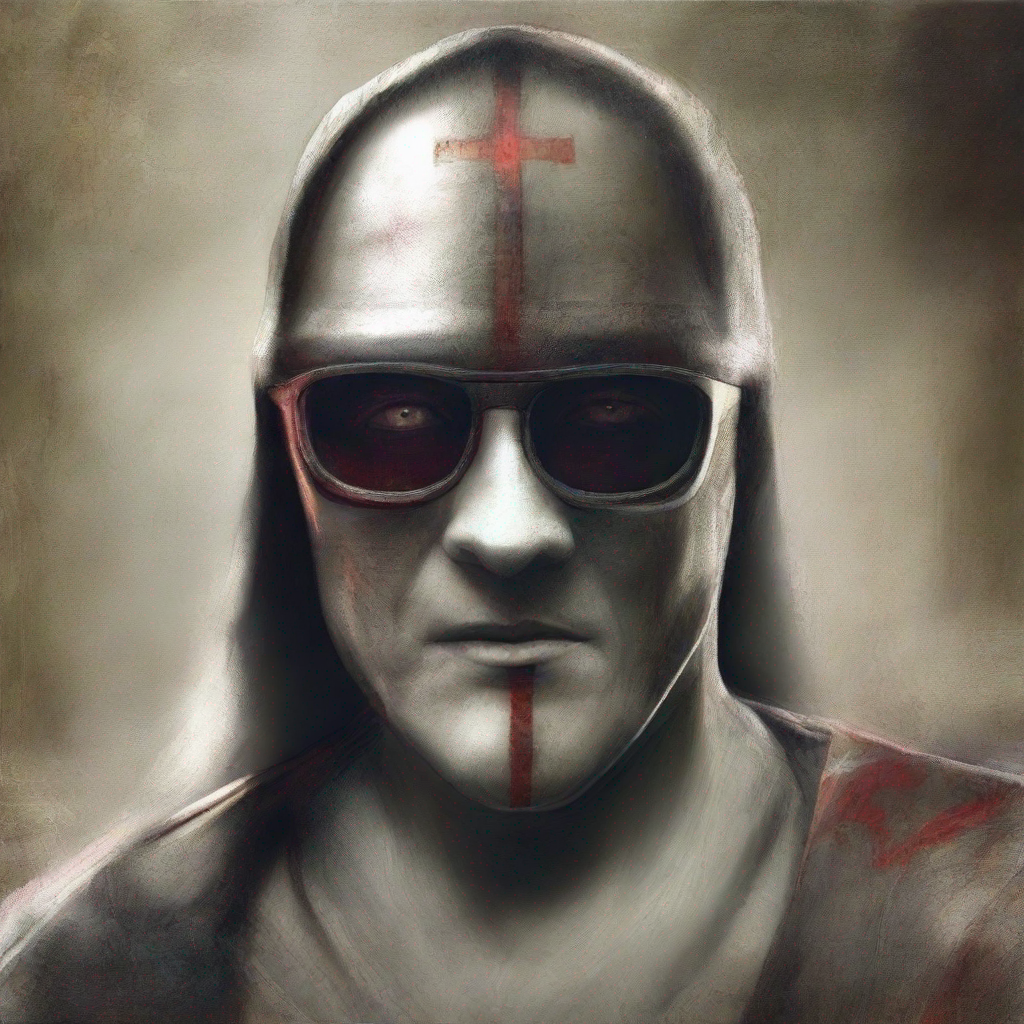

In [53]:
image